In [83]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from tqdm import tqdm
from scipy import stats
import numpy as np

In [84]:
train_embeddings = torch.load('./SMAI_A1/train_embeddings.pth', weights_only=True)
train_labels = torch.load('./SMAI_A1/train_labels.pth', weights_only=True)
print(train_embeddings.shape, train_labels.shape)

torch.Size([50000, 512]) torch.Size([50000])


In [85]:
test_embeddings = torch.load('./SMAI_A1/test_embeddings.pth', weights_only=True)
test_labels = torch.load('./SMAI_A1/test_labels.pth', weights_only=True)
print(test_embeddings.shape, test_labels.shape)

torch.Size([10000, 512]) torch.Size([10000])


In [86]:
text_embeddings = torch.load('./SMAI_A1/text_embedding.pth', map_location=torch.device('cpu'), weights_only=True)
print(text_embeddings.shape)
text_labels = torch.tensor(range(10))

torch.Size([10, 512])


In [87]:
class KMeansClusteringModel():
    def __init__(self, embeddings, distance_metric = 'cosine', k=10, epsilon=1e-5, max_iterations=10):
        self.embeddings = embeddings.cpu().numpy()
        self.k = k
        self.distance_metric = distance_metric
        self.epsilon = epsilon
        self.max_iterations = max_iterations
    def compute_distance_matrix(self, centroids):
        if self.distance_metric == 'cosine':
            return cosine_distances(self.embeddings, centroids)
        elif self.distance_metric == 'euclidean':
            return euclidean_distances(self.embeddings, centroids)
    def initialize_centroids_random(self):
        indices = np.random.choice(len(self.embeddings), self.k, replace=False)
        return self.embeddings[indices]
    def make_clusters(self):
        centroids = self.initialize_centroids_random()
        for _ in tqdm(range(self.max_iterations)):
            self.clusters = {i: {'indices': [], 'embeddings': []} for i in range(self.k)}
            distances = self.compute_distance_matrix(centroids)
            closest_centroids = np.argmin(distances, axis=1)
            for i in range(len(closest_centroids)):
                self.clusters[closest_centroids[i]]['indices'].append(i)
                self.clusters[closest_centroids[i]]['embeddings'].append(self.embeddings[i])
            new_centroids = np.array([np.mean(self.clusters[cluster]['embeddings'], axis=0, keepdims=True) if len(self.clusters[cluster]) > 0 else self.embeddings[np.random.randint(len(self.embeddings))] for cluster in self.clusters]).squeeze(1)
            shifts = [cosine_distances(centroids[i].reshape(1, -1), new_centroids[i].reshape(1, -1))[0][0] if self.distance_metric == 'cosine' else euclidean_distances(centroids[i].reshape(1, -1), new_centroids[i].reshape(1, -1))[0][0] for i in range(len(centroids))]
            max_shift = max(shifts)
            # print(max_shift)
            if max_shift < self.epsilon:
                break
            centroids = new_centroids
        self.centroids = centroids

                    

In [88]:

class IVFKNNRetrievalModel():
    def __init__(self, train_embeddings, test_embeddings, train_labels, test_labels, k=100, distance_metric='cosine', nprobe=2, n_clusters=10):
        self.train_embeddings = train_embeddings.cpu().numpy()
        self.test_embeddings = test_embeddings.cpu().numpy()
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.k = k
        self.distance_metric = distance_metric  
        self.nprobe = nprobe
        self.n_clusters = n_clusters 
        self.kmeans = None
    def compute_distance_matrix(self, queries, centroids):
        if self.distance_metric == 'cosine':
            return cosine_distances(queries, centroids)
        elif self.distance_metric == 'euclidean':
            return euclidean_distances(queries, centroids)
    def cluster_train_embeddings(self):
        self.kmeans = KMeansClusteringModel(torch.tensor(self.train_embeddings), distance_metric=self.distance_metric, k=self.n_clusters)
        self.kmeans.make_clusters()
        self.centroids = self.kmeans.centroids
        self.clusters = self.kmeans.clusters

    def retrieve_candidates(self, query_embedding, find_num_cands=0):
        query_embedding = query_embedding.reshape(1, -1)
        cluster_distances = self.compute_distance_matrix(query_embedding, self.centroids)
        closest_clusters = np.argsort(cluster_distances[0])[:self.nprobe]
        if find_num_cands:
            return sum([len(self.clusters[cluster]['embeddings']) for cluster in closest_clusters])
        candidate_embeddings = None
        candidate_indices = []
        for cluster in closest_clusters:
            candidate_indices.extend(self.clusters[cluster]['indices'])
            if candidate_embeddings is None:
                candidate_embeddings = np.array(self.clusters[cluster]['embeddings'])
            else:
                candidate_embeddings = np.concatenate((candidate_embeddings, np.array(self.clusters[cluster]['embeddings'])), axis=0)
        
        candidate_distances = cosine_distances(query_embedding, candidate_embeddings)[0] if self.distance_metric == 'cosine' else euclidean_distances(query_embedding, candidate_embeddings)[0]
        sorted_indices = np.argsort(candidate_distances)[:self.k]
        return [candidate_indices[i] for i in sorted_indices]  

    def evaluate(self):
        self.cluster_train_embeddings()  
        MRR = 0
        Precision = 0
        HR = 0
        for i in tqdm(range(len(self.test_embeddings))):
            retrieved_indices = self.retrieve_candidates(self.test_embeddings[i])
            possible_labels = [self.train_labels[index] for index in retrieved_indices]

            for j in range(len(possible_labels)):
                if possible_labels[j] == int(self.test_labels[i]):
                    MRR += (1 / (j +  1))
                    HR += 1
                    break
            for j in range(len(possible_labels)):
                if possible_labels[j] == int(self.test_labels[i]):
                    Precision += 1 / 100

        print(f'Results for {self.distance_metric} distance and k = {self.k} with {self.n_clusters} clusters:')
        print(f'Mean Reciprocal Rank: {MRR / len(self.test_embeddings):.4f}')
        print(f'Precision@100: {Precision / len(self.test_embeddings):.4f}')
        print(f'Hit Rate: {HR / len(self.test_embeddings):.4f}')


In [89]:
def plot_cluster_distribution(ivf_model):
    cluster_sizes = [len(ivf_model.clusters[i]['indices']) for i in range(ivf_model.n_clusters)]
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(ivf_model.n_clusters), cluster_sizes, color='skyblue')
    plt.xlabel("Cluster Index")
    plt.ylabel("Number of Points")
    plt.title("Number of Points in Each Cluster")
    plt.show()
def plot_comparisons_vs_nprobe(ivf_model, nprobe_values):
    comparisons = []

    for nprobe in nprobe_values:
        ivf_model.nprobe = nprobe
        total_comparisons = 0
        
        for i in tqdm(range(len(ivf_model.test_embeddings))):
            total_comparisons += ivf_model.retrieve_candidates(ivf_model.test_embeddings[i], find_num_cands=1)
        
        avg_comparisons = total_comparisons / len(ivf_model.test_embeddings)
        comparisons.append(avg_comparisons)

    plt.figure(figsize=(10, 6))
    plt.plot(nprobe_values, comparisons, marker='o', linestyle='-', color='red')
    plt.xlabel("nprobe")
    plt.ylabel("Average Comparisons per Query")
    plt.title("Average Comparisons per Query vs. nprobe")
    plt.grid()
    plt.show()

In [90]:

model = IVFKNNRetrievalModel(train_embeddings, test_embeddings, train_labels, test_labels, k=100, distance_metric='cosine', nprobe=2, n_clusters=10)
model.evaluate()


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [06:54<00:00, 24.12it/s]

Results for cosine distance and k = 100 with 10 clusters:
Mean Reciprocal Rank: 0.9338
Precision@100: 0.8399
Hit Rate: 0.9996


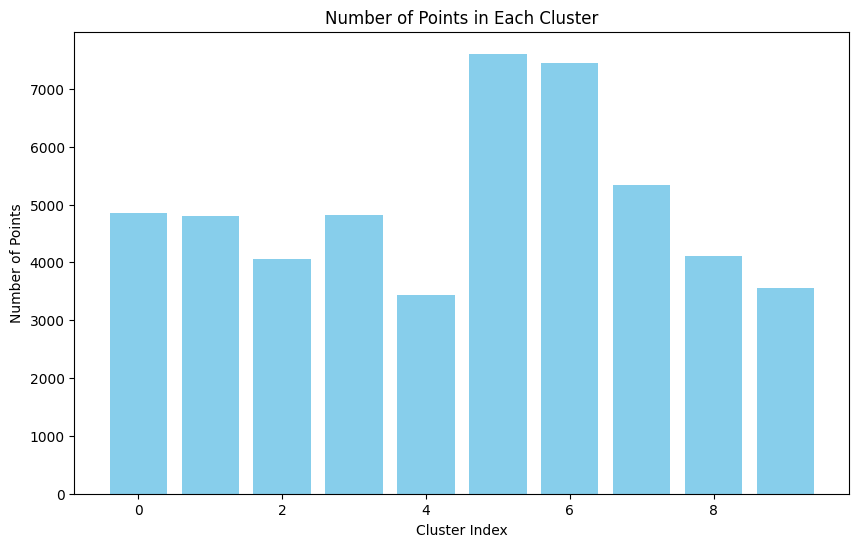

100%|██████████| 10000/10000 [00:02<00:00, 3344.37it/s]


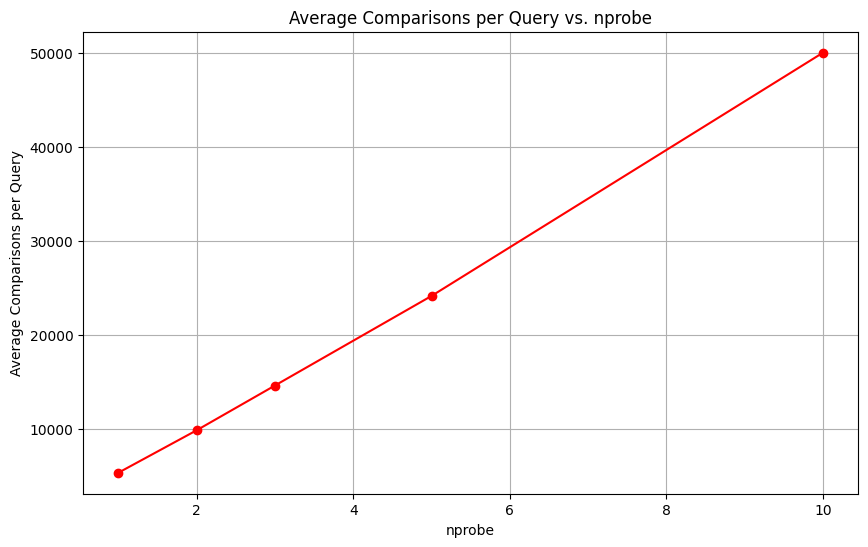

In [91]:
plot_cluster_distribution(model)

# Test with different nprobe values
nprobe_values = [1, 2, 3, 5, 10]
plot_comparisons_vs_nprobe(model, nprobe_values)


In [93]:
model = IVFKNNRetrievalModel(train_embeddings, test_embeddings, train_labels, test_labels, k=100, distance_metric='cosine', nprobe=5, n_clusters=10)
model.evaluate()
model = IVFKNNRetrievalModel(train_embeddings, test_embeddings, train_labels, test_labels, k=100, distance_metric='cosine', nprobe=8, n_clusters=10)
model.evaluate()

100%|██████████| 10000/10000 [17:58<00:00,  9.27it/s]


Results for cosine distance and k = 100 with 10 clusters:
Mean Reciprocal Rank: 0.9349
Precision@100: 0.8412
Hit Rate: 0.9995


100%|██████████| 10000/10000 [33:28<00:00,  4.98it/s]

Results for cosine distance and k = 100 with 10 clusters:
Mean Reciprocal Rank: 0.9348
Precision@100: 0.8411
Hit Rate: 0.9996
